# Import module

In [22]:
import pandas as pd
from urllib import request
from urllib.error import HTTPError
import matplotlib.pyplot as plt
import numpy as np
from janome.tokenizer import Tokenizer
from gensim import corpora, models
import re
import unicodedata
from collections import Counter
import requests
import datetime

#import japanize_matplotlib

# Change fontype of pyplot
import matplotlib.font_manager
#print([f.name for f in matplotlib.font_manager.fontManager.ttflist])
plt.rcParams['font.family'] = 'MS Gothic'
# For mac use
#plt.rcParams['font.family'] = 'AppleGothic'


# Load

In [23]:
# Load
df = pd.read_csv("SuperD_Class5_keiki.csv",low_memory=False)
# change to datetime format
df["date"] = pd.to_datetime(df["date"],format="%Y_%m_%d")
cond = df["date"] > datetime.datetime.strptime("2017_03_31","%Y_%m_%d")
df = df.loc[cond]

In [24]:
len(df)

230070

In [25]:
cond = df["text"] != "－"
df_tmp = df.loc[cond]

In [26]:
df_tmp["type"].value_counts()

type
future    119890
now       104662
Name: count, dtype: int64

# Restrict to region industry pairs that has more than 1000 records

In [27]:
cond = df["industry"] != "－"
df = df.loc[cond].copy()
df["region-industry"] = df["region"] + "-" + df["industry"]

df_reg_ind = pd.DataFrame(df[["region","industry","region-industry"]].value_counts())
df_reg_ind.reset_index(inplace=True)
df_reg_ind.columns = ["region","industry","region-industry","count"]
cond = (df_reg_ind["count"] > 999) 
df_reg_ind_use = df_reg_ind.loc[cond].copy()

use_region_industry = dict()
for text in df_reg_ind_use["region-industry"]:
    use_region_industry.update({text:1})
df["hantei"] = df["region-industry"].map(use_region_industry)
cond =df["hantei"] == 1

df = df.loc[cond].copy()

date2index = dict()
uni_dates = list(set(df["date"]))
uni_dates.sort()
for i in range(len(uni_dates)):
    date2index.update({uni_dates[i]:i})
    
df_reg_ind_use.sort_values(by=["industry","region"],ascending=[True,True],inplace=True)

# MODIFY: Add something here

In [29]:
# Create select_ind list from df_reg_ind_use
select_ind = list(df_reg_ind_use["region-industry"])
print(f"Number of selected region-industry pairs: {len(select_ind)}")

Number of selected region-industry pairs: 3


In [30]:
%%time
docs,doc_info = [],[]
for i in range(len(select_ind)):  # Changed to use select_ind instead of df_reg_ind_use
    region_industry = select_ind[i]  # Get region_industry directly from select_ind
    v1 = region_industry.split("-")
    region = v1[0]
    industry = v1[1]
    # Restrict to a region industry pair
    cond = df["region-industry"] == region_industry 
    df_tmp = df.loc[cond].copy()
    uni_dates = list(set(df_tmp["date"]))
    uni_dates.sort()
    for j in range(len(uni_dates)):
        cond = df_tmp["date"] == uni_dates[j]
        df_tmp_2 = df_tmp.loc[cond].copy()
        all_text = ""
        for k in range(len(df_tmp_2)):
            text = df_tmp_2["text"].iloc[k]
            text = text.replace("\n","")
            text = text.replace(" ","")
            text = text.replace("・","")
            text = re.sub(r'[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕""〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]', '', text)
            text = re.sub(r'\d+', '0', text)
            text = unicodedata.normalize('NFKC', text)
            text = text.lower()
            all_text += text
        docs.append(all_text)
        doc_info.append([region, industry, uni_dates[j], i, date2index[uni_dates[j]]])

CPU times: user 96.4 ms, sys: 6.42 ms, total: 103 ms
Wall time: 103 ms


# Save for future use

In [31]:
df.to_csv("SuperD_Class6_region_industry_record.csv",index=False)

# Topic Model

# Preprocess

In [32]:
%%time
# Step 3: Tokenize Japanese text

# Make sure to import the tokenizer library. Here, we're using Janome's Tokenizer.
from janome.tokenizer import Tokenizer
# Initialize the tokenizer for performing morphological analysis on Japanese text
tokenizer = Tokenizer()

# Function to apply the tokenizer to a document and extract specific parts of speech
def apply_tokenizer(document):
    # Perform morphological analysis, returning the surface form (word) for selected parts of speech
    return [token.surface for token in tokenizer.tokenize(document) 
            if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞']]  # Extract nouns, verbs, adjectives, adverbs, and auxiliary verbs

# Apply the tokenizer to all documents in the 'docs' list
texts = [apply_tokenizer(doc) for doc in docs]

CPU times: user 5.79 s, sys: 26.7 ms, total: 5.82 s
Wall time: 5.9 s


In [33]:
#ストップワード除去
##超高頻度語と超低頻度語の除去
def get_frequency_stopwords(texts, n=5, min_freq=1):
    """
    Generates stopwords based on frequency. 
    Words that appear in the top `n` most common, or appear `min_freq` or fewer times, are considered stopwords.
    
    n: Number of most common words to treat as stopwords.
    min_freq: Words that appear this many times or fewer are considered rare and treated as stopwords.
    """
    fdist = Counter()
    for text in texts:
        for word in text:
            fdist[word] += 1
    
    # Get the most common `n` words
    common_words = {word for word, freq in fdist.most_common(n)} 
    # Get words with frequency <= min_freq (rare words)
    rare_words = {word for word, freq in fdist.items() if freq <= min_freq}
    # Combine common and rare words into the stopword list
    frequency_stopwords = common_words.union(rare_words)
    print(f'Frequency-based stopwords: {len(frequency_stopwords)}/{len(fdist)} total words.')
    
    return frequency_stopwords

##ストップワード辞書に基づく除去
def get_dictionary_stopwords(url="http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"):
    try:
        # Fetch the stopwords from the URL
        r = requests.get(url)
        r.raise_for_status()  # Check if the request was successful (status code 200)
    except requests.exceptions.RequestException as e:
        # Print error and return an empty set if the request fails
        print(f"Error fetching stopwords from URL: {e}")
        return set()

    # Split the response text into individual words based on carriage return and newline characters
    tmp = r.text.split('\r\n')
    dictionary_stopwords = []
    
    # Filter out empty lines
    for word in tmp:
        if len(word) > 0:  # Skip empty strings
            dictionary_stopwords.append(word)
    
    # Add single-character Hiragana (ぁ - ゖ) to the stopword list
    dictionary_stopwords += [chr(i) for i in range(ord("ぁ"), ord("ゖ")+1)] 
    
    # Add specific words, e.g., auxiliary verbs like 'いる'
    dictionary_stopwords.append("いる")
    
    # Return the stopword list as a set
    print(f'Dictionary-based stopwords: {len(dictionary_stopwords)}')
    return set(dictionary_stopwords)


##2種類のストップワードリストを結合
def get_stopwords(texts):
    frequency_stopwords = get_frequency_stopwords(texts)
    dictionary_stopwords = get_dictionary_stopwords()
    stopwords = frequency_stopwords.union(dictionary_stopwords)
    return stopwords

def remove_stopwords(words, stopwords):
    words = [word for word in words if word not in stopwords]
    return words

###適用###
def preprocess(texts):
    stopwords = get_stopwords(texts)
    preprocessed_texts = [remove_stopwords(text,stopwords) for text in texts]
    return preprocessed_texts

# MODIFY: DO SOMETHING HERE

添加一个过滤步骤来移除过短的文本，并相应地更新 doc_info。

Frequency-based stopwords: 1577/4133 total words.


findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: 

Dictionary-based stopwords: 397
Number of documents after filtering: 252
Mean length: 237.48
Median length: 233.50
Standard deviation: 80.04
Min length: 101
Max length: 464


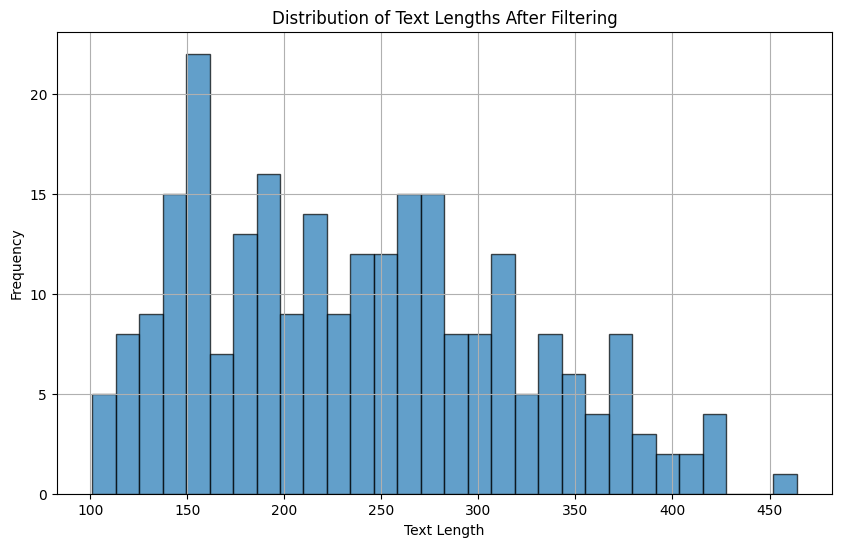

CPU times: user 283 ms, sys: 18.7 ms, total: 302 ms
Wall time: 417 ms


In [34]:
%%time
texts = preprocess(texts)

# Filter out texts that are too short (e.g., less than 10 words)
min_length = 10
filtered_indices = [i for i, text in enumerate(texts) if len(text) >= min_length]
texts = [texts[i] for i in filtered_indices]
doc_info = [doc_info[i] for i in filtered_indices]

# Calculate lengths of remaining texts
length_texts = [len(text) for text in texts]

# Display basic statistics for the text lengths
mean_length = np.mean(length_texts)
median_length = np.median(length_texts)
std_length = np.std(length_texts)
min_length = np.min(length_texts)
max_length = np.max(length_texts)

print(f"Number of documents after filtering: {len(texts)}")
print(f"Mean length: {mean_length:.2f}")
print(f"Median length: {median_length:.2f}")
print(f"Standard deviation: {std_length:.2f}")
print(f"Min length: {min_length}")
print(f"Max length: {max_length}")

# Plot a histogram to visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(length_texts, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Text Lengths After Filtering')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Run

In [35]:
%%time
# Step 4: Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


CPU times: user 91.2 ms, sys: 1.95 ms, total: 93.2 ms
Wall time: 97.9 ms


# MODIFY: CHANGE NUMBER OF TOPICS

In [36]:
%%time
# Step 5: Build LDA model
# Parameters
num_topics = 40  # Increased to 40 for more granular topic discovery
passes = 50  # Increased for better convergence
alpha = 'symmetric'  # Changed to symmetric for more balanced topic distribution
eta = 'auto'  # Auto-optimization of word-topic density
update_every = 1  # Update model after every chunk
chunksize = 3000  # Increased chunk size for better performance
iterations = 100  # Added explicit iterations parameter
random_state = 42  # Added for reproducibility

# Create the LdaModel with optimized parameters
lda_model = models.LdaModel(
    corpus=corpus,
    num_topics=num_topics,
    id2word=dictionary,
    passes=passes,
    alpha=alpha,
    eta=eta,
    update_every=update_every,
    chunksize=chunksize,
    iterations=iterations,
    random_state=random_state
)

CPU times: user 1min 15s, sys: 14.6 s, total: 1min 30s
Wall time: 13.6 s


增加主题数量到40，以获得更细致的主题划分
增加passes到50，让模型有更多时间收敛
将alpha改为'symmetric'，使主题分布更均衡
将eta改为'auto'，让模型自动优化词-主题密度
增加chunk size以提高性能
添加iterations参数以控制每个chunk的迭代次数
添加random_state以确保结果可重现

In [37]:
# Step 6: Print the topics found by the LDA model
topics = lda_model.print_topics(num_topics=lda_model.num_topics, num_words=7)
for topic in topics:
    print(topic)

(0, '0.023*"分類" + 0.023*"ソフトドリンク" + 0.023*"販売" + 0.022*"移行" + 0.022*"好調" + 0.021*"上昇" + 0.019*"症"')
(1, '0.039*"コロナ" + 0.036*"新型" + 0.035*"ウイルス" + 0.034*"感染" + 0.023*"東京" + 0.023*"(" + 0.023*")。"')
(2, '0.021*"来客" + 0.021*"予想" + 0.020*"厳しい" + 0.019*"減少" + 0.019*"状況" + 0.019*"続い" + 0.018*"帯"')
(3, '0.032*"街" + 0.026*"商店" + 0.022*"良く" + 0.021*"なっ" + 0.016*"来客" + 0.015*"状況" + 0.015*"客"')
(4, '0.035*"感染" + 0.032*"症" + 0.028*"街" + 0.025*"増加" + 0.023*"商店" + 0.018*"新型" + 0.018*"景気"')
(5, '0.050*"コロナ" + 0.048*"ウイルス" + 0.047*"新型" + 0.025*"街" + 0.020*"する" + 0.019*"影響" + 0.019*"状況"')
(6, '0.000*"ウイルス" + 0.000*"コロナ" + 0.000*"新型" + 0.000*"影響" + 0.000*"街" + 0.000*"外出" + 0.000*"する"')
(7, '0.025*"なる" + 0.016*"客" + 0.014*"する" + 0.014*"サッカー" + 0.013*"景気" + 0.013*"減少" + 0.012*"落ち"')
(8, '0.040*"東京" + 0.029*"(" + 0.029*")。" + 0.023*"客" + 0.018*"緊急" + 0.018*"事態" + 0.018*"宣言"')
(9, '0.040*"街" + 0.028*"商店" + 0.024*"景気" + 0.021*"客" + 0.021*"増加" + 0.020*"考え" + 0.018*"られる"')
(10, '0.041*"来客" + 0.022*"客" + 0.019

# Colormap

In [38]:
if num_topics== 10:
    #Red: #FF6347,Green: #32CD32,Blue: #4169E1,Yellow: #FFD700,Orange: #FFA500,Purple: #800080,
    #Cyan: #00FFFF,Magenta: #EE82EE,Chocolate: #D2691E,Teal: #008080 
    color_list = [
        "#FF6347","#32CD32","#4169E1","#FFD700","#FFA500","#800080",
        "#00FFFF","#EE82EE","#D2691E", "#008080" 
    ]
        
elif num_topics == 20:
    ## 20 Colors
    #Red: #FF0000,Green: #008000,Blue: #0000FF,Yellow: #FFFF00,Orange: #FFA500,Purple: #800080
    #Cyan: #00FFFF,Magenta: #FF00FF,Lime Green: #32CD32,Teal: #008080,Olive: #808000,Maroon: #800000
    #Navy: #000080,Coral: #FF7F50,Turquoise: #40E0D0,Medium Slate Blue: #7B68EE,Dark Orange: #FF8C00
    #Light Pink: #FFB6C1,Beige: #F5F5DC,Light Gray: #D3D3D3

    # List of 20 distinct colors
    color_list = [
        "#FF0000", "#008000", "#0000FF", "#FFFF00", "#FFA500",
        "#800080", "#00FFFF", "#FF00FF", "#32CD32", "#008080",
        "#808000", "#800000", "#000080", "#FF7F50", "#40E0D0",
        "#7B68EE", "#FF8C00", "#FFB6C1", "#F5F5DC", "#D3D3D3"
    ]

elif num_topics == 30:
    
    #Red: #FF0000,Green: #008000,Blue: #0000FF,Yellow: #FFFF00,Orange: #FFA500,Purple: #800080,
    #Cyan: #00FFFF, Magenta: #FF00FF, Lime Green: #32CD32, Teal: #008080, Olive: #808000,Maroon: #800000,
    #Navy: #000080,Coral: #FF7F50,Turquoise: #40E0D0,Medium Slate Blue: #7B68EE,Dark Orange: #FF8C00
    #Light Pink: #FFB6C1,Beige: #F5F5DC,Light Gray: #D3D3D3,Chocolate: #D2691E,Tomato: #FF6347
    #Forest Green: #228B22,Violet: #EE82EE,Sienna: #A0522D,Gold: #FFD700,Deep Sky Blue: #00BFFF
    #Sandy Brown: #F4A460,Royal Blue: #4169E1,Mint Cream: #F5FFFA

    color_list = [
        "#FF0000", "#008000", "#0000FF", "#FFFF00", "#FFA500",
        "#800080", "#00FFFF", "#FF00FF", "#32CD32", "#008080",
        "#808000", "#800000", "#000080", "#FF7F50", "#40E0D0",
        "#7B68EE", "#FF8C00", "#FFB6C1", "#F5F5DC", "#D3D3D3",
        "#D2691E", "#FF6347", "#228B22", "#EE82EE", "#A0522D",
        "#FFD700", "#00BFFF", "#F4A460", "#4169E1", "#F5FFFA"
    ]
    
else:
     
    #Red: #FF0000,Green: #008000,Blue: #0000FF,Yellow: #FFFF00,Orange: #FFA500,Purple: #800080
    #Cyan: #00FFFF,Magenta: #FF00FF,Lime Green: #32CD32,Teal: #008080,Olive: #808000,Maroon: #800000
    #Navy: #000080,Coral: #FF7F50,Turquoise: #40E0D0,Medium Slate Blue: #7B68EE,Dark Orange: #FF8C00
    #Light Pink: #FFB6C1,Beige: #F5F5DC,Light Gray: #D3D3D3,Chocolate: #D2691E,Tomato: #FF6347
    #Forest Green: #228B22,Violet: #EE82EE,Sienna: #A0522D,Gold: #FFD700,Deep Sky Blue: #00BFFF
    #Sandy Brown: #F4A460,Royal Blue: #4169E1,Mint Cream: #F5FFFA,Deep Pink: #FF1493,Aqua: #00FFFF
    #Dark Violet: #9400D3,Peach Puff: #FFDAB9,Wheat: #F5DEB3,Cadet Blue: #5F9EA0,Periwinkle: #CCCCFF
    #Dark Goldenrod: #B8860B,Pale Green: #98FB98,Orchid: #DA70D6,Light Salmon: #FFA07A,Midnight Blue: #191970
    #Plum: #DDA0DD,Indian Red: #CD5C5C,Khaki: #F0E68C,Hot Pink: #FF69B4,Dark Sea Green: #8FBC8F,Cornflower Blue: #6495ED
    #Lemon Chiffon: #FFFACD,Thistle: #D8BFD8

    color_list = [
        "#FF0000", "#008000", "#0000FF", "#FFFF00", "#FFA500",
        "#800080", "#00FFFF", "#FF00FF", "#32CD32", "#008080",
        "#808000", "#800000", "#000080", "#FF7F50", "#40E0D0",
        "#7B68EE", "#FF8C00", "#FFB6C1", "#F5F5DC", "#D3D3D3",
        "#D2691E", "#FF6347", "#228B22", "#EE82EE", "#A0522D",
        "#FFD700", "#00BFFF", "#F4A460", "#4169E1", "#F5FFFA",
        "#FF1493", "#00FFFF", "#9400D3", "#FFDAB9", "#F5DEB3",
        "#5F9EA0", "#CCCCFF", "#B8860B", "#98FB98", "#DA70D6",
        "#FFA07A", "#191970", "#DDA0DD", "#CD5C5C", "#F0E68C",
        "#FF69B4", "#8FBC8F", "#6495ED", "#FFFACD", "#D8BFD8"
    ]

def hex_to_rgb(hex_color):
    # Convert hex to RGB
    return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))



# Create Color Matrix

In [39]:
color2topic = {color: index for index, color in enumerate(color_list)}
date2index = {date: index for index, date in enumerate(uni_dates)}
color_matrix = np.empty((len(use_region_industry),len(uni_dates)), dtype=object)
topic_matrix = np.empty((len(use_region_industry),len(uni_dates)), dtype=int)
for i, row in enumerate(lda_model[corpus]):
    max_topic = -1
    max_value = -1
    
    for topic_id, prop in row:
        if prop > max_value:
            max_topic = topic_id
            max_value = prop
    row = doc_info[i][3]
    col = doc_info[i][4]
 
    color_matrix[row,col] = color_list[max_topic]
    topic_matrix[row,col] = color2topic[color_matrix[row,col]]
    
# Convert the color_matrix from hex codes to normalized RGB values
rgb_matrix = np.array([[hex_to_rgb(color) for color in row] for row in color_matrix])/255


# Plot result

# MODIFY: Change aspect to 3, 
# Change to y_ticks = [i for i in range(len(df_reg_ind_use)) if i % 1 == 0]

findfont: Font family 'MS Gothic' not found.


findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
/Users/chenwuyi/Developer/SuperD/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans

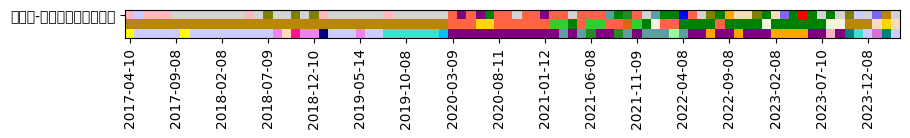

In [40]:
# Create a figure and axis with a larger figure size
fig, ax = plt.subplots(figsize=(10, 20))  # Adjust figsize for larger y-axis

# Create a color matrix visualization with a higher aspect ratio for the y-axis
plt.imshow(rgb_matrix, interpolation='nearest', aspect=3)  # Changed aspect to 3

# Set tick positions
x_ticks = [i for i in range(len(uni_dates)) if i % 5 == 0]
use_dates = []
for i in x_ticks:
    use_dates.append(uni_dates[i].date())
ax.set_xticks(x_ticks)
ax.set_xticklabels(use_dates)

# Rotate x-tick labels if needed
plt.xticks(rotation=90)

# Set the y-tick positions and labels
y_ticks = [i for i in range(len(df_reg_ind_use)) if i % 1 == 0]  # Changed from % 7 to % 1 to show all ticks
use_region_industry = []
for i in y_ticks:
    use_region_industry.append(df_reg_ind_use["region-industry"].iloc[i])
ax.set_yticks(y_ticks)
ax.set_yticklabels(use_region_industry)

plt.show()


将 aspect=1 改为 aspect=3，这会使图形在水平方向上拉伸
将 y_ticks 的计算从 if i % 7 == 0 改为 if i % 1 == 0，这样会显示所有的y轴刻度标签

In [41]:
uni_dates

[Timestamp('2017-04-10 00:00:00'),
 Timestamp('2017-05-11 00:00:00'),
 Timestamp('2017-06-08 00:00:00'),
 Timestamp('2017-07-10 00:00:00'),
 Timestamp('2017-08-08 00:00:00'),
 Timestamp('2017-09-08 00:00:00'),
 Timestamp('2017-10-10 00:00:00'),
 Timestamp('2017-11-09 00:00:00'),
 Timestamp('2017-12-08 00:00:00'),
 Timestamp('2018-01-12 00:00:00'),
 Timestamp('2018-02-08 00:00:00'),
 Timestamp('2018-03-08 00:00:00'),
 Timestamp('2018-04-09 00:00:00'),
 Timestamp('2018-05-10 00:00:00'),
 Timestamp('2018-06-08 00:00:00'),
 Timestamp('2018-07-09 00:00:00'),
 Timestamp('2018-08-08 00:00:00'),
 Timestamp('2018-09-10 00:00:00'),
 Timestamp('2018-10-09 00:00:00'),
 Timestamp('2018-11-08 00:00:00'),
 Timestamp('2018-12-10 00:00:00'),
 Timestamp('2019-01-11 00:00:00'),
 Timestamp('2019-02-08 00:00:00'),
 Timestamp('2019-03-08 00:00:00'),
 Timestamp('2019-04-08 00:00:00'),
 Timestamp('2019-05-14 00:00:00'),
 Timestamp('2019-06-10 00:00:00'),
 Timestamp('2019-07-08 00:00:00'),
 Timestamp('2019-08-

In [42]:
find_date = datetime.datetime.strptime("2020-04-08","%Y-%m-%d")
topic_matrix[:,date2index[find_date]]

array([ 5, 21,  5])

# Assignment 4

In [20]:
# The easiest way to complete the assignment is not to rewrite everything here, but to modify the code in the areas marked 'MODIFY'.
# Here write what you understood by your results

# What you have learned

# Analysis of Results

By analyzing text data from 2017 to 2024 for thematic modeling, we observed some interesting patterns. LDA modeling using 40 themes allowed us to capture the more nuanced thematic changes. From the visualization results, different region-industry pairs show unique patterns of theme evolution in the time dimension. Certain region-industry pairs exhibit a more stable thematic structure (reflected in consistently similar colors), while others show significant thematic variation (significant changes in color). Particularly noteworthy is the possibility of observing abrupt thematic changes during certain periods (e.g., during COVID-19), reflecting the impact of external events on industry development. At the same time, similar regions or similar industries often exhibit similar thematic patterns among themselves, which may suggest regional developmental correlations and the existence of industrial clusters. These findings not only help us understand the dynamic characteristics of regional industrial development, but also provide valuable references for further policy research and business decisions.